# Introducción

La predicción temprana de accidentes cerebrovasculares es un problema crítico dentro del ámbito de la salud pública. Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular constituye la segunda causa de muerte a nivel mundial y representa aproximadamente el 11% del total de fallecimientos globales. La posibilidad de anticipar estos eventos a partir de información clínica y demográfica habilita herramientas de prevención e intervención temprana.

En este trabajo práctico se desarrolla un modelo de aprendizaje automático orientado a predecir la probabilidad de que un paciente sufra un accidente cerebrovascular, utilizando como insumo el Stroke Prediction Dataset publicado en Kaggle. El objetivo es explorar las variables disponibles, realizar el preprocesamiento necesario, comparar distintas alternativas de modelado y finalmente seleccionar un algoritmo que permita obtener un desempeño robusto y clínicamente útil.

Fuente del dataset:
Federico Soriano, Stroke Prediction Dataset, Kaggle (2021).
Disponible en: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # uso este para aplicar SMOTE en el pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, ConfusionMatrixDisplay, precision_recall_curve, make_scorer, recall_score, fbeta_score

# AGREGO ESTO DESPUES DE HABER CORRIDO EL CODIGO COMPLETO Y EVALUADO TODOS LOS WARNINGS, SU OBJETIVO ES OCULTAR EL WARNING EN EL precision_recall_curve
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [2]:

def find_threshold(y_true, y_proba, beta=2, n_thresholds=200):
    """
    Busca el threshold óptimo que maximiza F-beta (por defecto F2).
    """
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    scores = []
    
    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        score = fbeta_score(y_true, y_pred_thr, beta=beta)
        scores.append(score)
    
    best_idx = int(np.argmax(scores))
    best_threshold = thresholds[best_idx]
    best_fbeta = scores[best_idx]
    
    return best_threshold, best_fbeta

El dataset contiene información de pacientes, tanto datos demográficos como factores de riesgo clínicos. Cada fila representa un individuo y cada columna un atributo relevante para la predicción. Las variables principales son:

Variables demográficas:

* gender: género del paciente
* age: edad del paciente
* ever_married: si alguna vez estuvo casado
* work_type: tipo de ocupación
* Residence_type: tipo de residencia (urbana o rural)

Variables clínicas:

* hypertension: presencia de hipertensión
* heart_disease: presencia de enfermedad cardíaca
* avg_glucose_level: nivel promedio de glucosa en sangre
* bmi: índice de masa corporal

Hábitos y estilo de vida:
* smoking_status: categoría de consumo de tabaco

Variable objetivo:

* stroke: indica si el paciente sufrió un accidente cerebrovascular (1) o no (0)

El dataset presenta un desbalance significativo, con un porcentaje muy bajo de casos positivos (5%), lo cual condiciona el tipo de modelos y métricas a utilizar.


# EDA

In [3]:
file_path = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(file_path)

In [4]:
# Configuracion general de graficos
sns.set(style="whitegrid", palette="deep", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores faltantes por columna:")
print(df.isna().sum())


print(df['work_type'])

Dimensiones del dataset: (5110, 12)

Primeras filas:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Valores faltantes por columna:
id                     0
gender                 0
age                    0
hypertension           0
hea

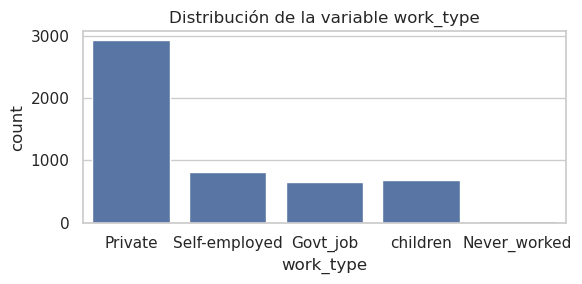

In [6]:
plt.figure(figsize=(6, 3))
sns.countplot(x='work_type', data=df)
plt.title('Distribución de la variable work_type')
plt.tight_layout()
plt.show()

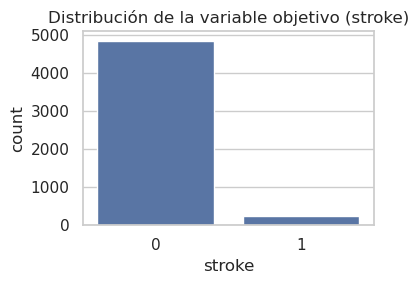

In [7]:
plt.figure(figsize=(4, 3))
sns.countplot(x='stroke', data=df)
plt.title('Distribución de la variable objetivo (stroke)')
plt.tight_layout()
plt.show()

### Distribucion de edad, nivel de glucosa y BMI


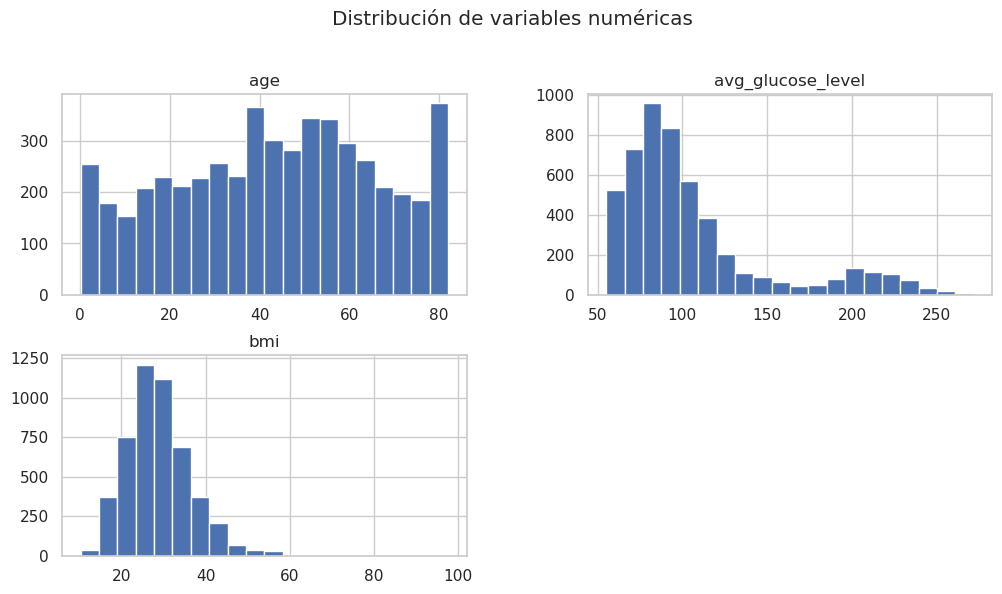

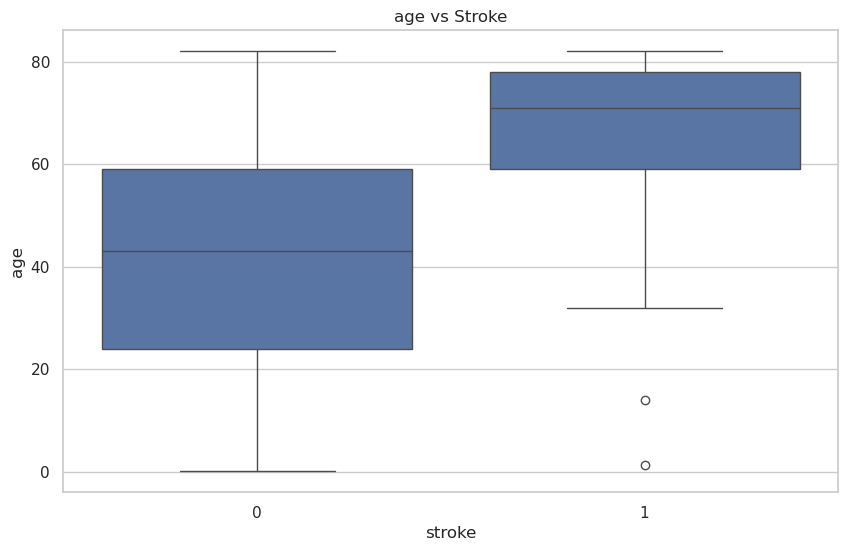

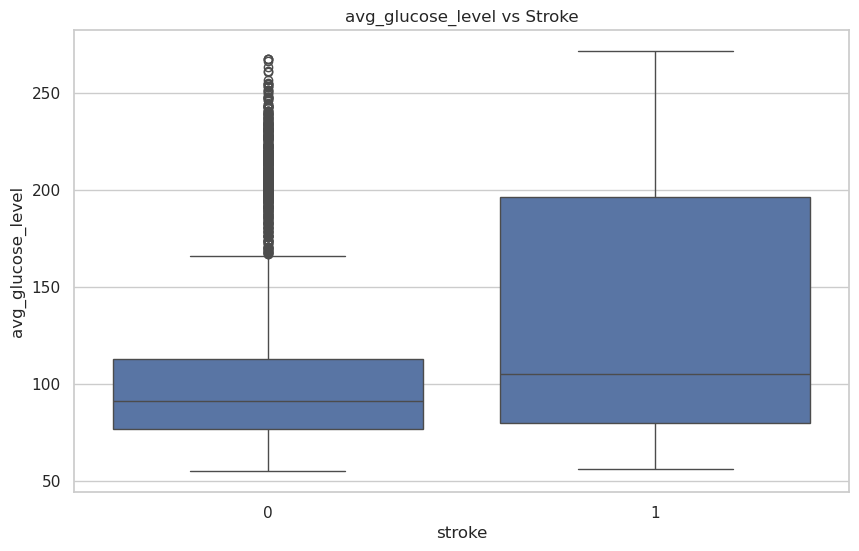

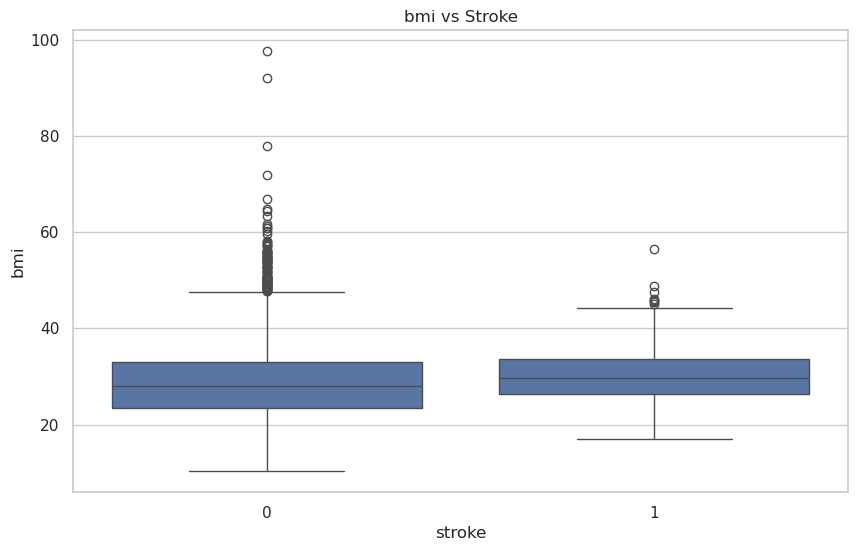

In [8]:
num_vars = ['age', 'avg_glucose_level', 'bmi']
df[num_vars].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribución de variables numéricas', y=1.02)
plt.show()

# comparanmos stroke vs variables numericas
for col in num_vars:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
    plt.show()

### Matriz de correlacion entre variables numericas

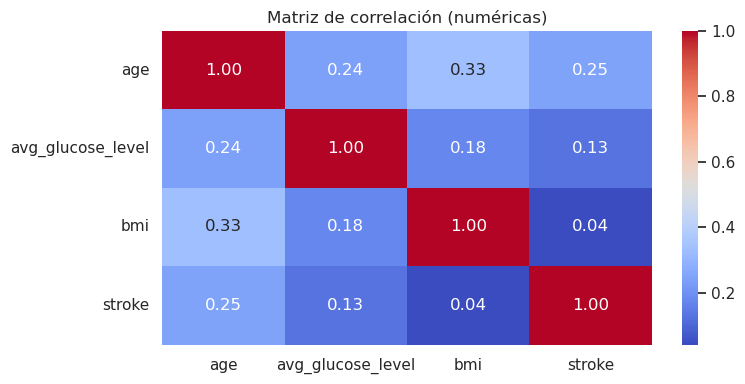

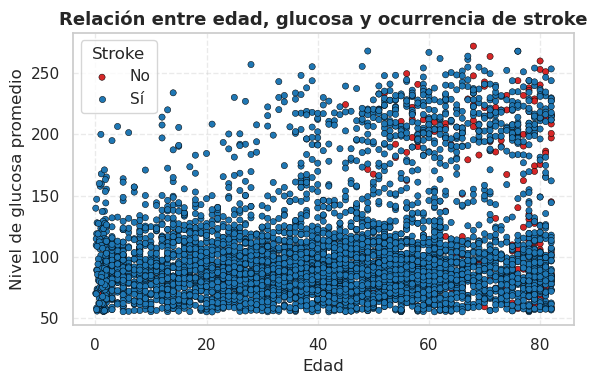

In [9]:
plt.figure(figsize=(8, 4))
corr = df[num_vars + ['stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (numéricas)')
plt.tight_layout()
plt.show()

# Relacion entre edad y nivel de glucosa, coloreado por stroke
plt.figure(figsize=(6, 4)) 
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    palette={0: '#1f77b4', 1: '#d62728'},  # azul fuerte para 0, rojo intenso para 1
    alpha=1,
    edgecolor='black',
    s=20  # tamaño de puntos
)
plt.title('Relación entre edad, glucosa y ocurrencia de stroke', fontsize=13, weight='bold')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend(title='Stroke', labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Distribuciones categoricas vs Target

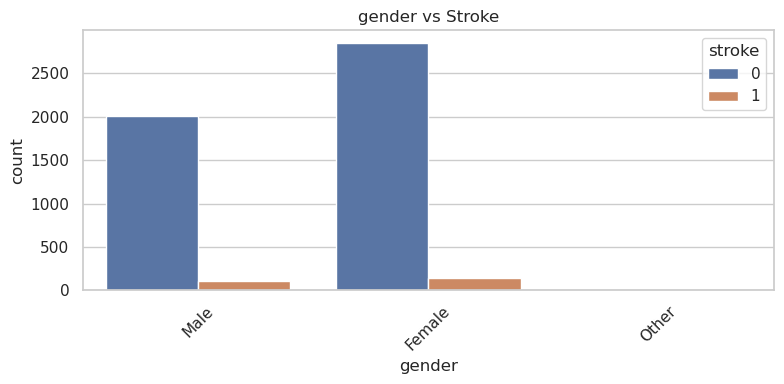

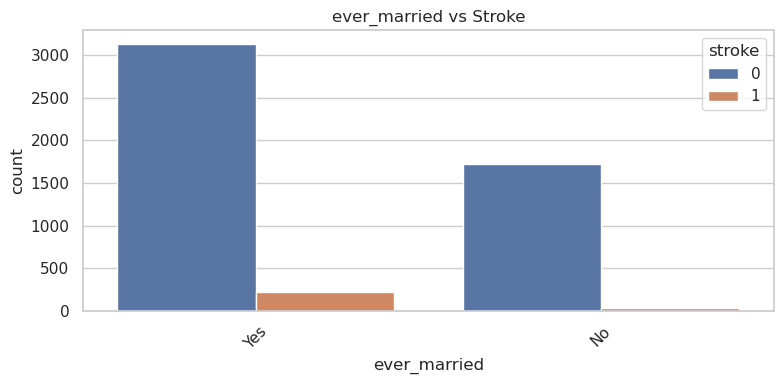

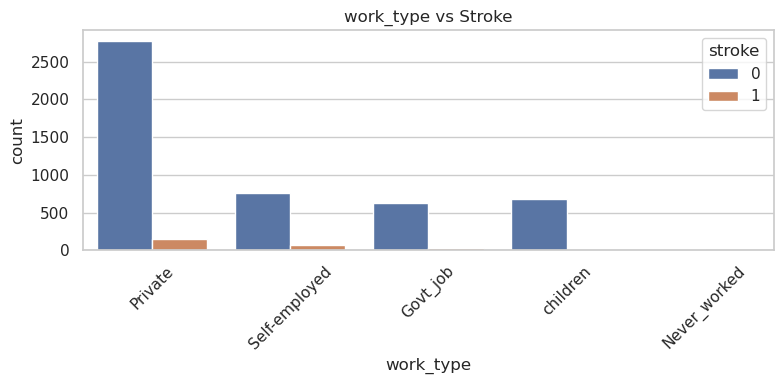

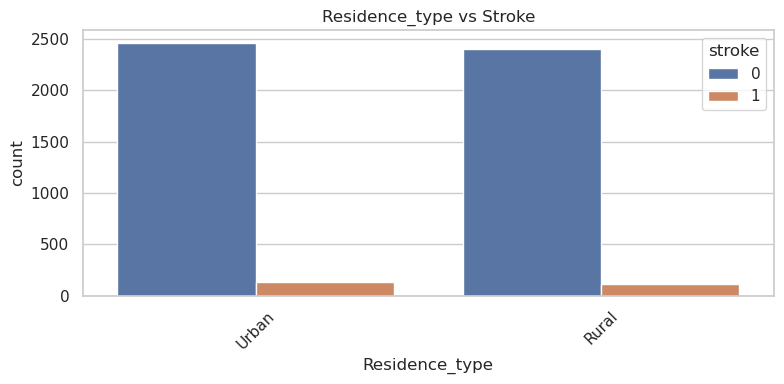

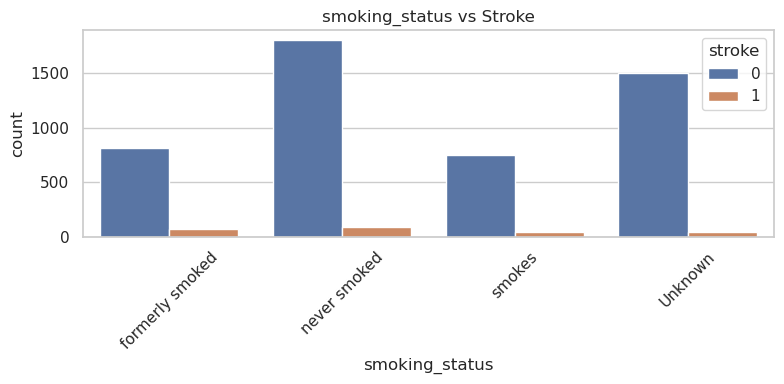

In [10]:
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Se separa el set de entrenamiento, validación y test

Previo a las transformaciones y balanceo de los datos, se procede a crear una división entre los sets de entrenamiento, validación y test. StratifiedKFold hace los folds para validación de hiperparámetros. El set de validación se usa para encontrar el threshold óptimo y test para evaluar el modelo definitivo.

In [11]:
# Pensemos si queremos cambiar el 0.3 a otro valor
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

# Primero: train + valid vs test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.85, stratify=y_temp)

# Transformaciones y tratamiento de Nulls

Con el objetivo de proveer datos numericos y validos al modelo de entrenamiento, utilizamos la media para rellenar los valores de BMI y most_frequent para las variables categoricas. Luego escalamos los valores numericos y aplicamos One-Hot encoding a las variables categoricas dado que tienen una baja cardinalidad.

In [12]:
df['bmi'] = df['bmi'].replace('N/A', np.nan).astype(float)

num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease',
                'ever_married', 'Residence_type',
                'smoking_status', 'work_type']

# se imputan valores faltantes con median + escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# se imputan valores faltantes + One-Hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Random Forest
Características:
* Maneja naturalmente tanto variables numéricas como categóricas sin requerir transformaciones complejas.
* Captura relaciones no lineales entre variables clínicas (edad, glucosa, BMI, etc.) gracias a la estructura basada en múltiples árboles.
* Es un modelo robusto al ruido, a valores atípicos y a diferencias de escala entre las variables.
* Tolera bien el desbalance de clases mediante el parámetro class_weight='balanced', lo cual ayuda a no ignorar los casos positivos de stroke.
* Ofrece un buen compromiso entre interpretabilidad, precisión, robustez y capacidad de generalización.

In [13]:
# Modelo y pipeline

modelo_rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_rf)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_rf = {
    # cantidad de arboles
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10, 15],
    'clf__min_samples_leaf': [1, 2, 4, 6],
    # numero de features en cada split
    'clf__max_features': ['sqrt', 'log2'],
    # se agrega para castigar los falsos negativos, importante en algunos casos clinicos
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 100 combinaciones aleatorias de parámetros
random_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=parametros_rf,
    n_iter=100,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print("Mejores hiperparámetros Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_

# Evaluación en VALIDACIÓN
y_pred_val = best_rf.predict(X_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores hiperparámetros Random Forest:
{'clf__n_estimators': 600, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 6, 'clf__max_features': 'log2', 'clf__max_depth': 5, 'clf__class_weight': 'balanced'}


In [14]:
# Determinación del mejor umbral

y_proba_val = best_rf.predict_proba(X_val)[:, 1]

best_threshold, best_f2 = find_threshold(y_val, y_proba_val)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2:.4f}")

Mejor threshold en VALIDACIÓN: 0.443
F2 en VALIDACIÓN con ese threshold: 0.4199


In [15]:
# Se entrena el modelo y predecimos
y_proba_test = best_rf.predict_proba(X_test)[:, 1]
threshold = best_threshold
y_pred_test = (y_proba_test >= threshold).astype(int)
y_proba_test_rf = y_proba_test # para el gráfico de curvas ROC
y_pred_test_rf = y_pred_test # para la matriz de confusión

# XGBoost
Características:
* Es un modelo basado en árboles que maneja naturalmente relaciones no lineales entre las variables sin necesidad de ingeniería de features adicional.
* Suele obtener mejor rendimiento que Random Forest en datos tabulares gracias al boosting, que corrige iterativamente los errores de los árboles anteriores.
* Permite un control fino del sobreajuste mediante hiperparámetros como learning_rate, max_depth y gamma.
* Se adapta bien al desbalance de clases mediante el parámetro scale_pos_weight, y puede combinarse con SMOTE dentro del pipeline.
* Mantiene buena robustez frente a ruido y valores extremos

In [16]:
# Modelo y pipeline
modelo_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_xgb)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_xgb = {
    'clf__n_estimators': [100, 200, 300, 500, 800],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__min_child_weight': [1, 3, 5],
    'clf__gamma': [0, 1, 3, 5],
    'clf__scale_pos_weight': [1, 3, 5, 10]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 125 combinaciones aleatorias de parámetros
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=parametros_grid_xgb,
    n_iter=125,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_

print("Mejores hiperparámetros XGBoost:")
print(random_search_xgb.best_params_)

# Evaluación en VALIDACIÓN
y_pred_val = best_xgb.predict(X_val)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Mejores hiperparámetros XGBoost:
{'clf__subsample': 0.8, 'clf__scale_pos_weight': 1, 'clf__n_estimators': 200, 'clf__min_child_weight': 5, 'clf__max_depth': 3, 'clf__learning_rate': 0.001, 'clf__gamma': 0, 'clf__colsample_bytree': 0.8}


In [17]:
# Determinación del mejor umbral

y_proba_val = best_xgb.predict_proba(X_val)[:, 1]

best_threshold, best_f2 = find_threshold(y_val, y_proba_val)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2:.4f}")

Mejor threshold en VALIDACIÓN: 0.527
F2 en VALIDACIÓN con ese threshold: 0.4575


In [18]:
# Se entrena el modelo y predecimos
y_proba_test = best_xgb.predict_proba(X_test)[:, 1]
threshold = best_threshold
y_pred_test = (y_proba_test >= threshold).astype(int)
y_proba_test_xgb = y_proba_test # para el gráfico de curvas ROC
y_pred_test_xgb = y_pred_test # para la matriz de confusión

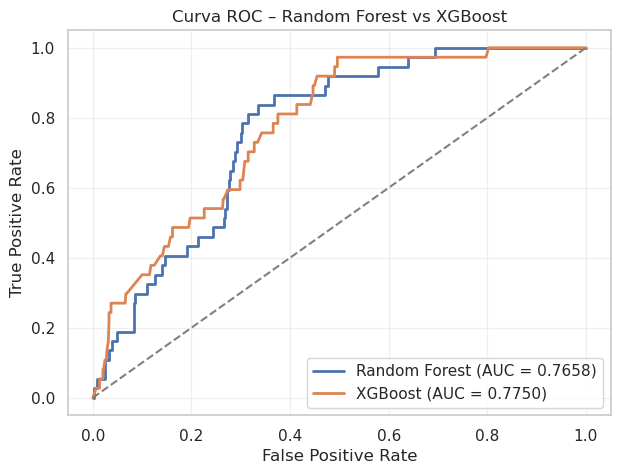

In [19]:
# Cálculo ROC de Random Forest
roc_auc_rf = roc_auc_score(y_test, y_proba_test_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_test_rf)

# Cálculo ROC de XGBoost
roc_auc_xgb = roc_auc_score(y_test, y_proba_test_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_test_xgb)

plt.figure(figsize=(7, 5))

# RF
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", linewidth=2)

# XGB
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})", linewidth=2)

# Diagonal
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Random Forest vs XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

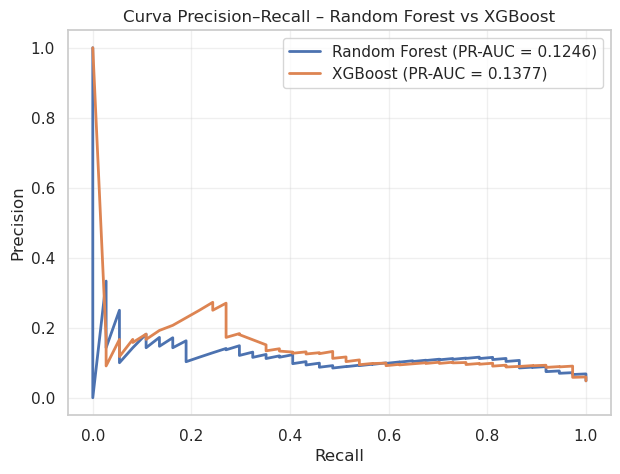

In [20]:
# PR Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_test_rf)
pr_auc_rf = average_precision_score(y_test, y_proba_test_rf)

# PR XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_test_xgb)
pr_auc_xgb = average_precision_score(y_test, y_proba_test_xgb)

plt.figure(figsize=(7, 5))

plt.plot(recall_rf, precision_rf, label=f"Random Forest (PR-AUC = {pr_auc_rf:.4f})", linewidth=2)
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (PR-AUC = {pr_auc_xgb:.4f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall – Random Forest vs XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

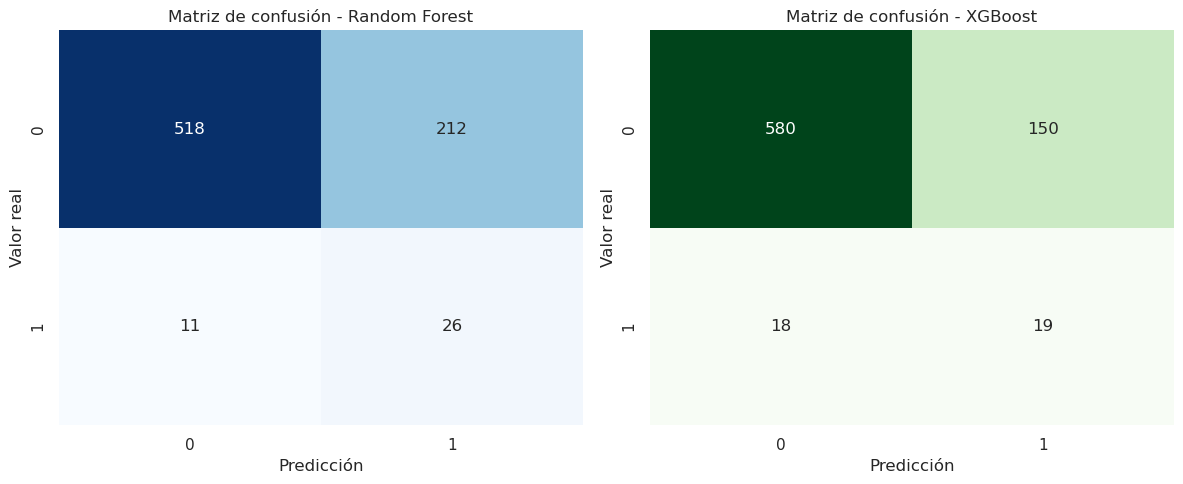

In [21]:
# Matrices de confusión
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Matriz de confusión - Random Forest")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Valor real")

# XGBoost
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Matriz de confusión - XGBoost")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Valor real")

plt.tight_layout()
plt.show()
